## Double Well Potential with MCMC

Paul Cretegny, Ethan Newell, Katya Sumwalt

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

Consider the double well potential,
$$ V(x) = αx^4 -2x^2 + \frac{1}{α}$$
where x is the position of the particle, and we set m = h_bar = 1 and α = 0.4. See Refs. [1, 2] for discussions of
similar problems.

Use the path integral formulation with imaginary time τ:

$$ Z = \int\ Dx(τ) exp [-\frac{1}{h} \oint_{0}^{\tau_b} L_E(x(τ))dτ \, dx] $$



Problem A : Evaluate the ground state energy and probability distribution of the particle using Markov
chain Monte Carlo with the Metropolis-Hastings algorithm in the large-τb (imaginary time) limit. Describe
your strategy for determining τb, the initial configuration, burn-in steps, hit size, number of sweeps, and
thinning (if any).


In [80]:
SWEEPS = 200_000
TAU = 30
DELTATAU = 1
NTAU = int(TAU/DELTATAU)
HITSIZE = 0.1

ALPHA = 0.4

XLOW = -4
XHIGH = 4
NXBINS = 100
OMEGA = 1
M = 1
DELTAX = (XHIGH - XLOW) / NXBINS
prob_histogram = np.zeros(NXBINS)
x_bins = np.linspace(XLOW, XHIGH, NXBINS + 1)

x_path = np.zeros(NTAU)


In [81]:
def V(x):
    return ALPHA * x**4 - 2 * x**2 + 1/ALPHA
@njit
def vary_path(x_current):
    x_prime = x_current + np.random.random() * 2 * HITSIZE - HITSIZE
    while x_prime > XHIGH or x_prime < XLOW:
        x_prime = x_current + np.random.random() * 2 * HITSIZE - HITSIZE
    return x_prime
# @njit
def action(x_left, x_right):
    K = 0.5 * M * (((x_right - x_left))**2) / DELTATAU
    v = 0.5 * M * DELTATAU * (OMEGA**2) * V((x_left + x_right) / 2)
    return K + v
@njit
def total_action(x_path):
    path_action = 0
    for i in range(-1, NXBINS-1):
        path_action += action(x_path[i], x_path[i+1])
    return path_action
# @njit
def delta_action(x_path, x_prime, i):
    x_left = x_path[i-1]
    x_right = x_path[i+1] if i < NTAU-1 else x_path[0] #PBC.
    daction = action(x_left, x_prime) + action(x_prime, x_right) 
    daction -= action(x_left, x_path[i]) + action(x_path[i], x_right) #compute the resulting change from u in delta S.
    return daction
# @njit
def MCMC(x_path, prob_histogram):
    for i in range(NTAU):
        x_prime = vary_path(x_path[i])
        daction = delta_action(x_path, x_prime, i)
        if daction <= 0:            
            x_path[i] = x_prime
        else:        
            prob = np.exp(-daction)
            if np.random.random() < prob:
                x_path[i] = x_prime
    hist, _ = np.histogram(x_path, bins=x_bins)
    prob_histogram += hist

In [ ]:
for k in range(SWEEPS):
    MCMC(x_path,prob_histogram)
# Should take 1.5 minutes to compute with 200_000 SWEEPS


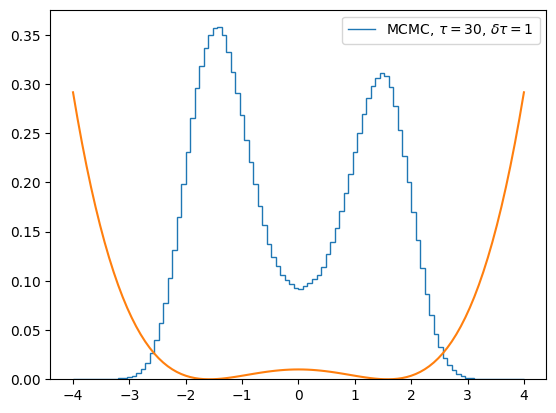

In [ ]:
plt.figure()
plt.stairs(prob_histogram/np.sum(prob_histogram*DELTAX), x_bins, label=f"MCMC, $\\tau = {TAU}$, $\\delta\\tau={DELTATAU}$")
# plt.plot(x_bins, psi_analytical*psi_analytical.conjugate(), label="Analytical")
# plt.plot(x_bins,V(x_bins)/250)
plt.legend()
plt.show()

Problem B: Plot the ground state probability distribution and compare it with the expected form.

Problem C : Calculate the energy and probability distribution of the particle from the same simulation
code for a smaller value of τb. What is the expected probability distribution in this case? What does this
correspond to in terms of a statistical mechanics interpretation?